# Voiture autonome dans un environnement dynamique

Les routes du plateau sont souvent traversées par des petites voitures bleues avec un plot sur la tête. Ce spectacle étrange a éveillé notre curiosité et nous a fait nous demander si nous pouvions, avec nos connaissances, modeliser une voiture autonome en ville. Nous sommes donc partis des données des taxis a New York (https://chriswhong.com/open-data/foil_nyc_taxi/) pour simuler un trafic réaliste en ville. Le cours de M. Remy sur l'apprentissage par renforcement ainsi que son application dans le notebook GridWorld nous a donné une base à l'elaboration de cette intelligence artificielle (IA) capable de conduire dans le trafic.<p>
Comment adapter l'apprentissage par renforcement de problèmes statiques à la resolution dynamique de contournement du trafic ?

## Modelisation du problème

L'IA a un objectif simple : elle part d'un point A et doit aller jusqu'à un point B, tout deux choisis préalablement à l'éxecution.

Les tracés blancs représentent les routes tandis que les batiments sont entourés par des contours noirs. Toutes les routes sont à double-sens et les voitures roulent à droite. Les taxis sont représentés par des rectangles jaunes et l'intelligence artificielle (IA) par un rectangle bleu. La case de depart de l'IA et son point d'arrivé sont en violets.

Les taxis ont des trajectoires fixes et répètent leur parcours en retournant directement à leur point de départ après avoir terminé leur course. Les taxis peuvent se croiser et se chevaucher et ils roulent à droite.

L'IA se déplace afin d'atteindre son point d'arrivé. Elle roule à droite et ne peux rentrer en collision avec d'autres taxis.
À chaque instant l'IA peut décider de se déplacer vers l'avant, vers l'arrière, à droite et à gauche où bien de s'arréter. Elle ne peut faire demi-tour qu'à des intersections.

Ci dessous un exemple de ce qu'est la grille :

<img src="Ressources/exemple_map_1.png">

### Recupération des données

Pour arriver à cette carte, plusieurs étapes de transformation ont été necessaire en partant du fichier **trip_data_1.csv**. Dans ce dernier seules les coordonnées géographiques de départ et d'arrivée des taxis sont renseignées, le fichier **read_data.py** permet le traitement de ces données et leur transformation en coordonnées entières pour les placer dans la grid. 

Le traitement est fait par la fonction select_data
```python
def select_data(file, n_trips, L_dim, l_dim, method_selection =  None) :
    """
    Select all taxis from file that are in relative square L_dim x l_dim 
    
    args :
        file(Pandas DF): data of the taxi trips in NY
        n_trips(int): the number of trips you want to select
        L_dim(float), l_dim(float): dimension relative de la grid par rapport à la taille de New York
        method_selection(str): How to select the data specificelly
    
    Returns :
        Pandas Df
    """
    
```

La transformation en coordonnées entière est réalisé par la fonction convert_data
```python
def convert_data (data_taxi,density):
    """
    Convert the raw coordinates of the taxi from data_taxi to int coordinates in a grid 
    that respect the density parameter
    
    Args :
        data_taxi(pandas DF): the original coordinates from the NYC taxi
        density(float): the number of taxi in each cell of the grid
        
    Returns :
        taxis(list of taxi)
        long,large(int) the length of the grid
    """
```

A l'issue de l'éxecution de cette fonction on récupère une liste d'objet taxi de la classe taxi
```python
class taxi(object):
    """
    A class that contains basic information about the taxis
    
    Attributes :
        departure(tuple of int): departure position in the grid
        arrival(tuple of int) : arrival position in the grid
        position(tuple of int): current position of the taxi in the grid
        trip(list of tuple): positions of the taxi at each instant
    """
```

En pratique cela s'éxecute de cette facon

In [1]:
import codes
import importlib
importlib.reload(codes)

import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from codes import utils
from codes.Env import Env
from codes.GridWorld import GridWorld, full_grid_generator, ispuissance
from codes.LearningRate import LearningRate
from codes.Q import Q
from codes.PolicyEpsilonGreedy import PolicyEpsilonGreedy
from codes.Q_learning_dynamic import Q_learning_dynamic
import codes.read_data as read_data


mon_fichier = pd.read_csv("Ressources/trip_data_1.csv")

mon_fichier = mon_fichier.replace(0.0,np.nan)# clean rapide des position fausses
mon_fichier = mon_fichier.dropna(how='any',axis = 0)

In [2]:
df_taxis  = read_data.select_data(mon_fichier, 5, 0.5, 0.5)
taxis,long,large = read_data.convert_data (df_taxis,0.2)

### Trajectoire des taxis dans la grid

Chaque taxi de la liste de taxis taxis a une coordonnée de départ et une coordonnnée d'arrivé dans la grid.

Au départ la grid est pleine, elle est quadrillée à l'aide de la fonction full_grid_generator, il n'y a aucune route.
<img src="Ressources/exemple_grid_pleine.png">
À chaque départ et arrivée de taxi la grid est creusée à la manière de Bomberman, c'est à dire que toute la longueure et toute la hauteur deviennent des routes.
<img src="Ressources/exemple_grid_creusée.png">
Ensuite la grid est dédoublée pour permettre la circulation dans les deux sens.
<img src="Ressources/exemple_grid_dédoublée.png">

On peut ensuite instancier un objet de GridWorld
```python
class  GridWorld(object):
    """A class to generate and interact with a gridworld environement

    Attributes:
        Q (Q): The empirical Q function of the environement.
        V (V): The empirical Value function of the environement.
        x, y (int): Coordinates of the agent in the grid.
        t (int): The time stamp in the current run.
        path (list): The path taken during the current run

    Methods:
        reset(self, random_init: bool=False, state: Optional[Tuple[int]]=None)
              -> None:
            Resets the agent to the start/random/required position and time to 0.
        step(self, action: Union[str, int]) 
             -> Tuple[Union[Tuple[int], int, bool, None]]:
            Perfomrs the asked action
        dedoublement(self)
            -> None
            Doubles the Grid in order to model two-way roads from one-way road 
            It updates the start_coordinates, the end_coordinates and the grid to model
            a two-way road and adds the start positions of the taxis in the grid.
        taxis_trips(self)
            -> None
            Create the path for every taxis on the Grid.
            For each taxis the attribute traxi.trip is created.It describes the road-way
            the taxi will hit.
        next_table(self)
            -> None
            Update the table from t to t+1
            Every taxis move on his next position
        render_path_and_V(self, scale: int=1.5) -> None:
            Plots the path taken by the agent and the Value function.
        render_board(self, scale= float:1.5, show: bool=True,
                     fig: bool=False) -> None:
            displays a figure with the labirynth.
        render_path(self, fig: bool=False, show: bool=True) -> None:
            Plots the path taken by the agent up to now
        render_V(self, fig: bool=False, show: bool=True,from: str='Q') -> None:
            Plots the Value function

    Constants:
        ACTION_SPACE (list): The possible actions in int
        ACTION_DICT (dict): The possible actions in strings
            "up", "right", "down", "left"
    """
```

In [3]:
my_grid = GridWorld(full_grid_generator(large,long),taxis,(0,0),(2,4))

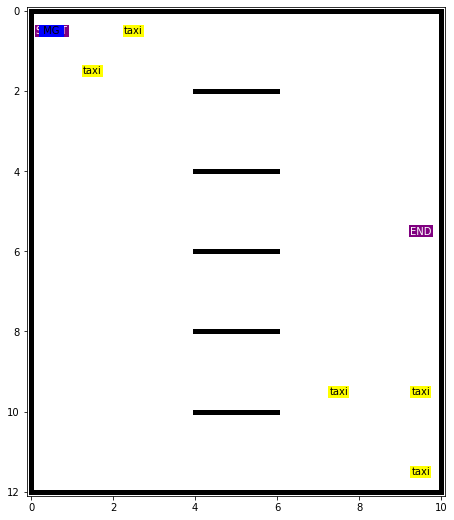

In [4]:
my_grid.render_board()

## Resolution du problème

### Introduction au Q-learning


#### Processus de décison Markovien

Avant de commencer un problème d'apprentissage par renforcement(RL), definissons le processus markovien :
* Un espace d' <b>etat</b> $\mathcal{X}$.
* Un état d' <b>action</b> $\mathcal{A}$.
* Une <b>transition</b> de distribution probabiliste $p(x'|x,a)$. "Quel est l'espace des possibilités quand une action est prise dans un certain état ?".
* Une fonction <b>reward</b>  $r(x,a)$. "Qu'obtient t'on en faisant une certaine action dans un certain état ?".


Donc, l'action de l'IA ne dépend que de l'état dans laquelle elle est, pas de son passé

#### La fonction Value et l'équation de Bellman

Définissons la fonction <b>Valeur</b> $V$ comme la récompense totale à laquelle nous pouvons nous attendre lorsque nous sommes dans un certain état. Cela dépend de la fonction <b>policy</b> que nous choisissons. La politique $\pi(a|x)$ est définie par l'opérateur, et définit l'action à entreprendre en fonction de l'état. Ensuite, la fonction de valeur est définie par :

\begin{equation}
    V^\pi(x) = \mathbb{E}\Big[\sum_{t=0}^T \gamma^t r(x_t, a_t) \Big| x_0, \pi \Big]
\end{equation}

Où $\gamma$ est la réduction dans le temps et $T$ est le pas de temps final aléatoire.

Désignons par $\pi^*$ la politique optimale, c'est-à-dire la politique qui maximise la fonction de valeur à chaque état, et par $V^*$ la fonction de valeur résultante.

Si la politique est stationnaire, c'est-à-dire qu'elle ne change pas avec le temps, ce qui est le cas pour la politique optimale, alors la fonction valeur suit l'équation <b>Bellman</b> :

\begin{equation}
    V^*(x) = r(x,\pi^*(x)) + \gamma \sum_{x' \in \mathcal{X}} p(x'|x,\pi^*(x)) V^*(x')
\end{equation}
Où $\pi^*(x)$ est l'action retournée par la politique optimale.

#### Q-Learning

Au lieu d'essayer d'apprendre la fonction de valeur $V(x)$ pour tous les états, le Q-learning consiste à apprendre la fonction $Q$ qui associe chaque couple d'état et d'action à la récompense finale attendue.
La fonction de valeur associée d'une fonction $Q$ sous la politique $\pi$ est :

\begin{equation}
    V^{\pi}(x) = \sum_{a \in \mathcal{A}} \pi(a|x) Q(x, a)
\end{equation}

Si nous définissons la politique optimale comme étant la politique gourmande $\pi^*(x) = \arg\max_a Q^*(x, a)$. Alors la fonction optimale $Q$ suit l'équation de Bellman. Nous pouvons utiliser ceci pour approximer $Q^*$ avec l'algorithme <b>Q-learning</b> :

<b>Initialisation</b> $Q_0$ randomly  
<b>For</b> $e = 1, \dots,n$:  
> <b>Intiate</b> $t = 0, x_0$  
> <b>While</b> $x_t$ <b>not</b> terminal:  
>> <b>Choose</b> $a_t$ according to a suitable <b>exploration policy</b>  
>> <b>Observe</b> $r_t = r(x_t, a_t)$, $x_{t+1}$  
>> <b>Temporal difference</b> $\delta_{t} = r_t$ <b>If</b> $x_t$ is terminal <b>Else</b> $r_t + \gamma \max_{a}Q(x_{t+1}, a) - Q(x_t, a)$  
>> <b>Update</b> $Q(x_t, a_t) =  Q(x_t, a_t) + \alpha(x_t, a_t) \delta_t$  

Si le taux d'apprentissage $\alpha_t$ satisfait les conditions <b>Robbins-Monro</b> $\sum_{t=0}^{\infty} \alpha_t = \infty$ et $\sum_{t=0}^{\infty} \alpha_t^2 < \infty$ pour chaque couple d'action d'état, et chaque état est visité infiniment souvent alors la convergence vers la fonction optimale $Q$ est garantie (presque de façon aléatoire).

### La policy $\epsilon$-Greedy 

Plus tôt, nous avons parlé d'une <b>"suitable exploration policy"</b>. 
La politique  $\epsilon$-greedy choisit une action comme suit :
* Avec une probabilité $\epsilon$ la politique retourne $\arg\max_a Q(x_t, a)$
* Avec une probabilité de $1-\epsilon$ la politique choisit uniformément <u>un autre</u> état

```python
class PolicyEpsilonGreedy(object):
    """This is an implementation of the epsilon greedy policy with respect to a
    provided Q-table

    Methods:
        __init__(self, Q: Q, action_space: List[Union[int, str]], 
                 epsilon: float, decay: float, lower: float, 
                 decay_every: int) -> None:
            Initializes the Policy
        __call__(self, state: Union[np.array, List, int, str],
                 be_greedy: bool=False) -> Union[int, str]:
            Returns an action with respect to the policy
```

### Adaptation au problème dynamique

Ce processus d'apprentissage par renforcement ne fonctionne que si les états restent les mêmes, cependant dans notre cas entre deux instants, c'est à dire entre le deplacement d'un taxi d'une case à l'autre, les états changent car les taxis quittent une case pour aller sur une autre. Nous avont donc mis en place une fonction Q_learning_dynamic qui éxecute la fonction Q_learning à chaque instant t.
```python
def Q_learning_dynamic(Q_, env, gamma, print_every_episode, n_episodes, epsilon, epsilon_decay, epsilon_min,
              epsilon_decay_every, lr0, lr_decay, min_lr, max_steps,display = True) :
    """
    Calculate Q-table at each modification of the env env and displays the final path taken 
    
    Args :
        Q_(np.array) : the Q table
        env(GridWorld): the grid 
        print_every_episode(int): the frequency of the printing of the progress
        n_episodes(int): the number of episodes to update the Q table
        max_steps(int): the maximum number of iteration to do at each episode
        other args(float): parameter for the policy and the learning rate
        display(bool): displays the board at each modification of the env env
        
    Returns :
        env(GridWorld)
    """
```    

Starting training
100 episodes
Finished  episode 99 of 100 episodes. Mean reward: 0.8 (2.20)
Starting training
100 episodes
Finished  episode 99 of 100 episodes. Mean reward: 0.8 (2.00)
Starting training
100 episodes
Finished  episode 99 of 100 episodes. Mean reward: 0.7 (2.68)
Starting training
100 episodes
Finished  episode 99 of 100 episodes. Mean reward: 0.6 (3.23)
Starting training
100 episodes
Finished  episode 99 of 100 episodes. Mean reward: 0.9 (1.36)
Starting training
100 episodes
Finished  episode 99 of 100 episodes. Mean reward: 0.9 (1.42)
Starting training
100 episodes
Finished  episode 99 of 100 episodes. Mean reward: 1.0 (0.84)
Starting training
100 episodes
Finished  episode 99 of 100 episodes. Mean reward: 0.9 (1.70)
Starting training
100 episodes
Finished  episode 99 of 100 episodes. Mean reward: 0.9 (1.02)
Starting training
100 episodes
Finished  episode 99 of 100 episodes. Mean reward: 0.7 (2.94)
Starting training
100 episodes
Finished  episode 99 of 100 episodes. M

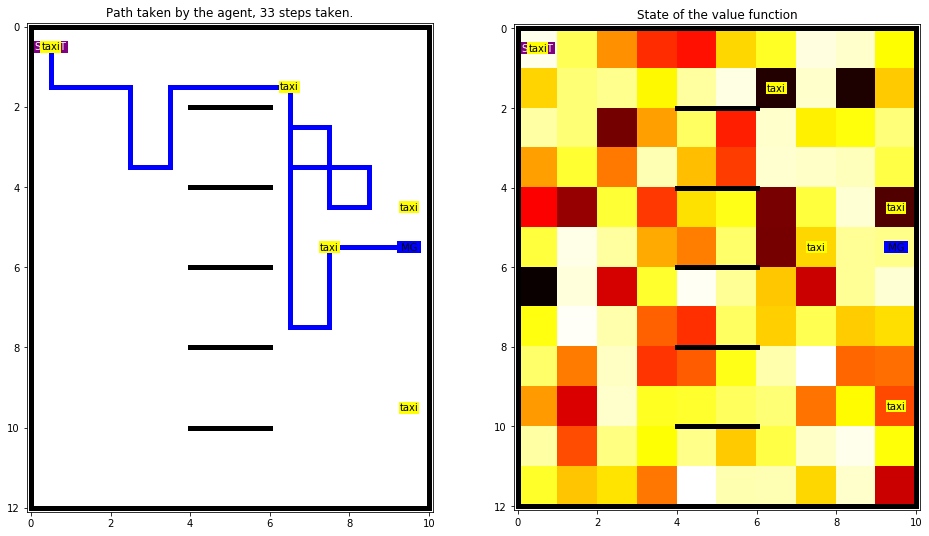

/Users/guillaumegiacomoni/Library/Mobile Documents/com~apple~CloudDocs/2A_ENSAE/S1/Python/Projet info 2A/codes/GridWorld.py:399: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(shape[1]*scale, shape[0]*scale))


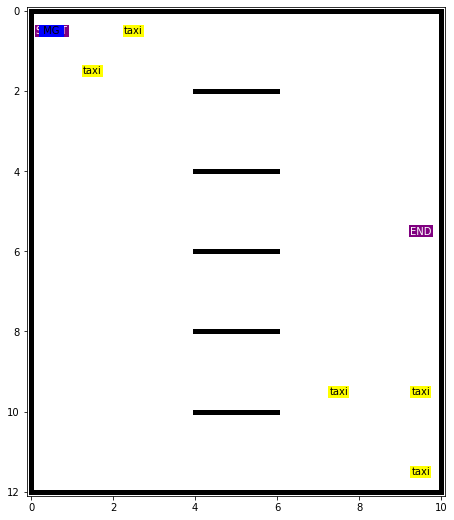

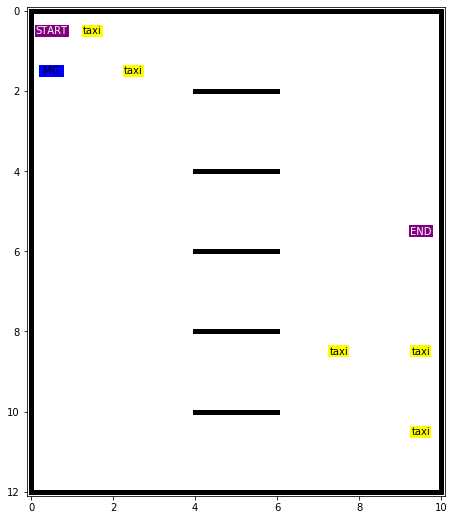

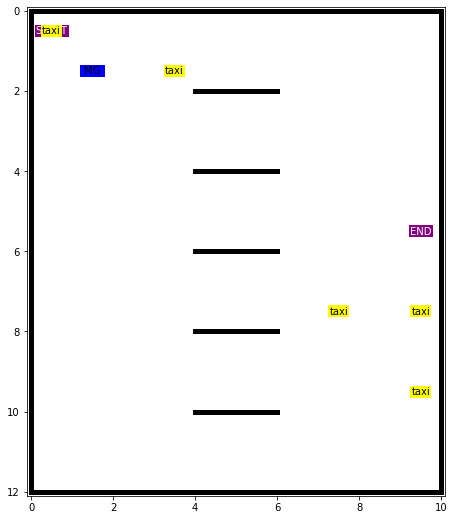

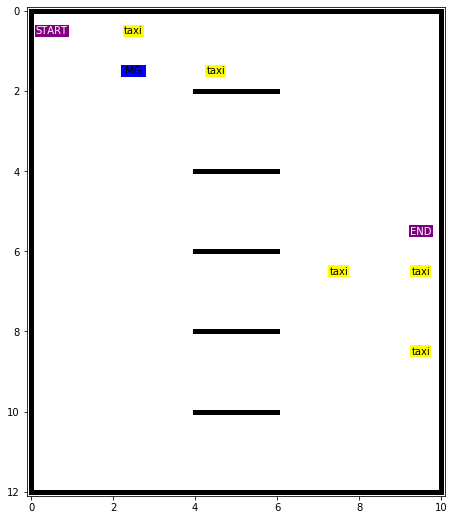

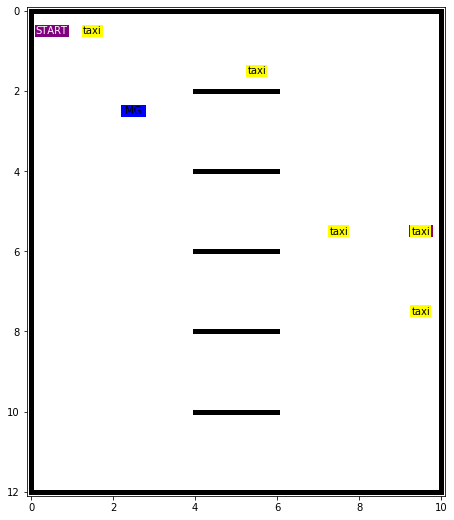

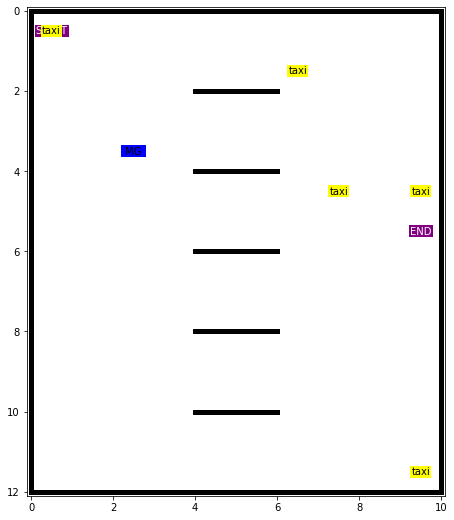

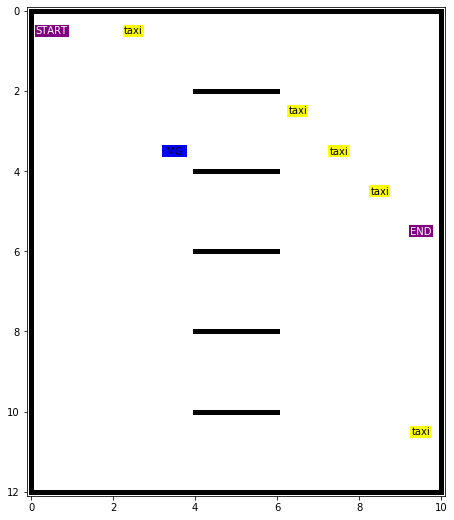

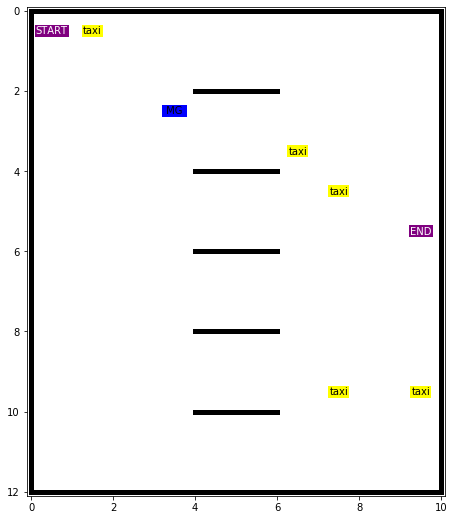

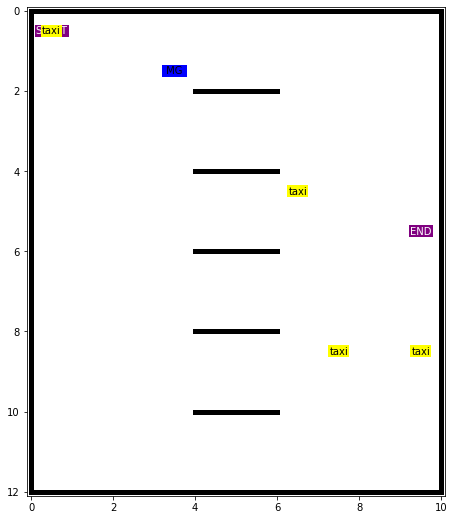

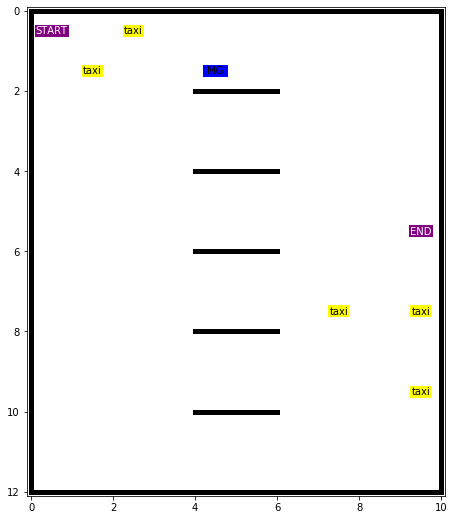

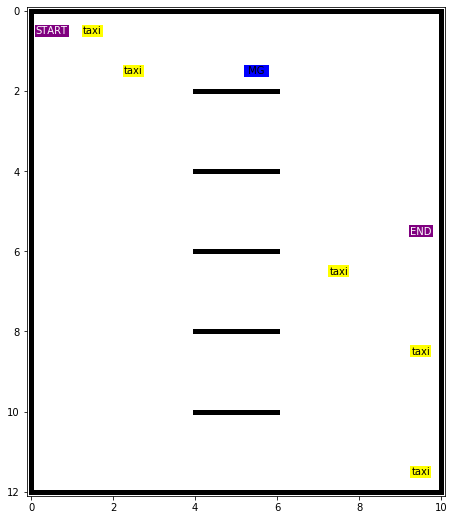

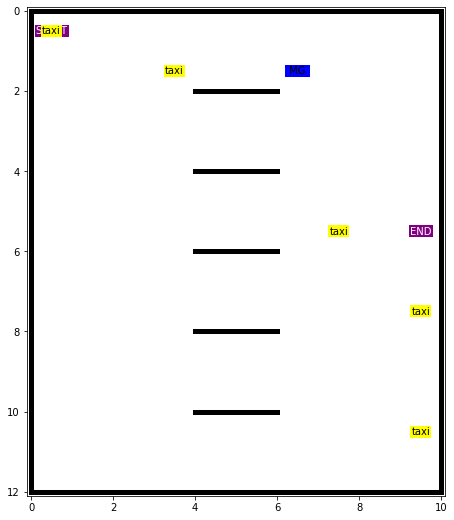

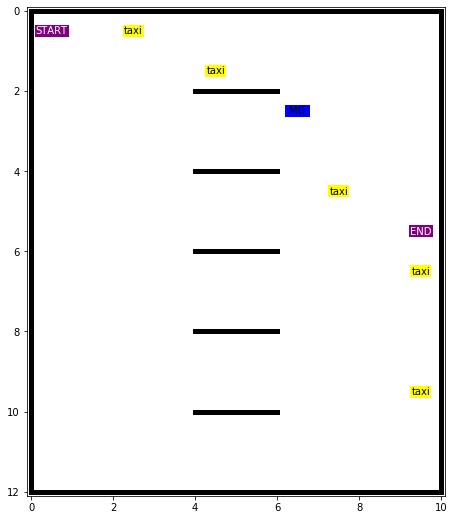

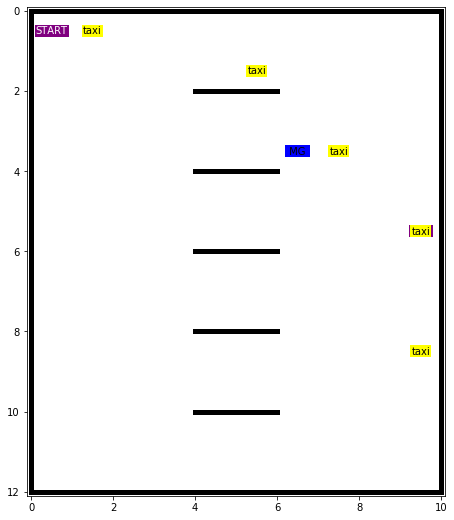

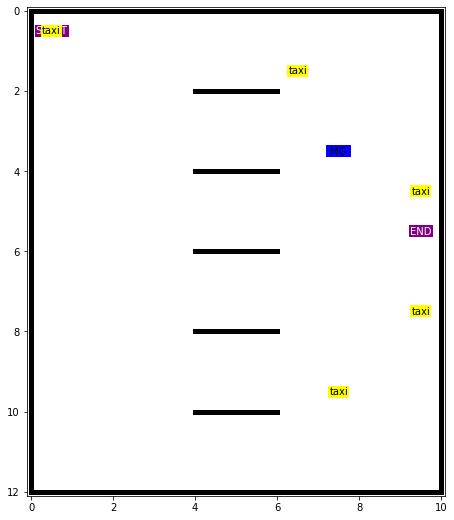

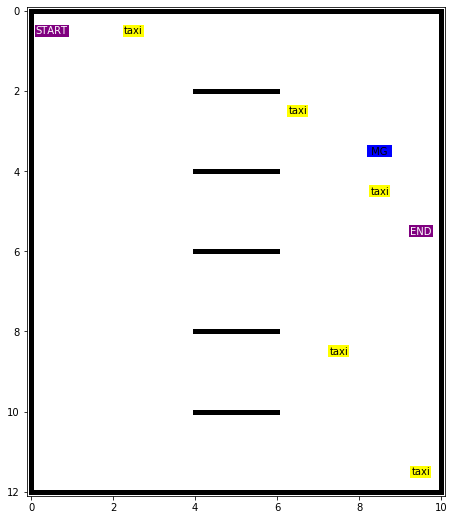

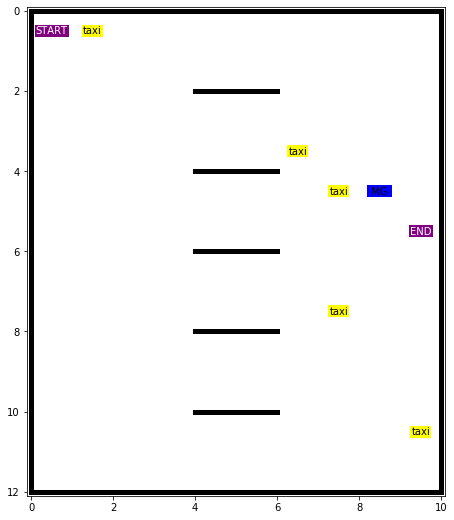

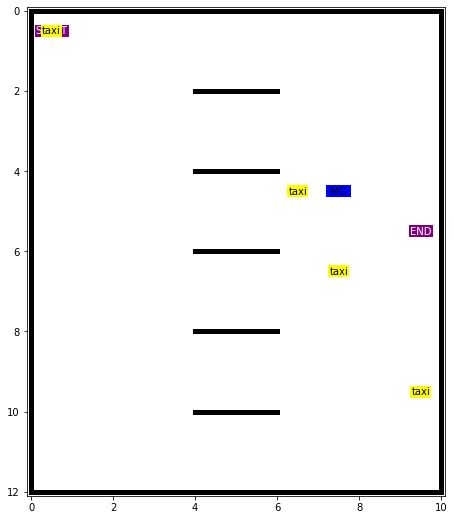

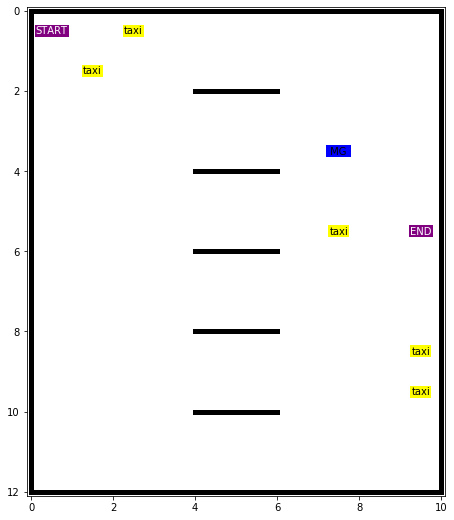

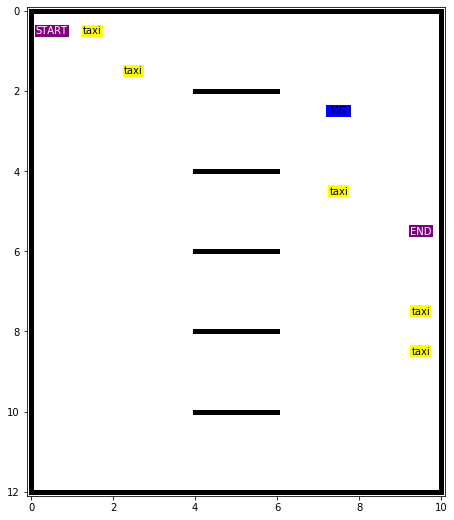

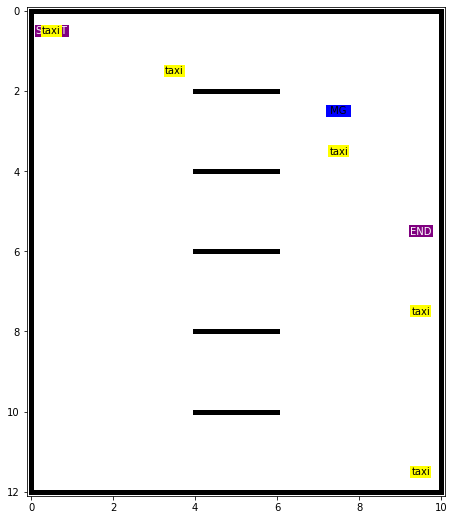

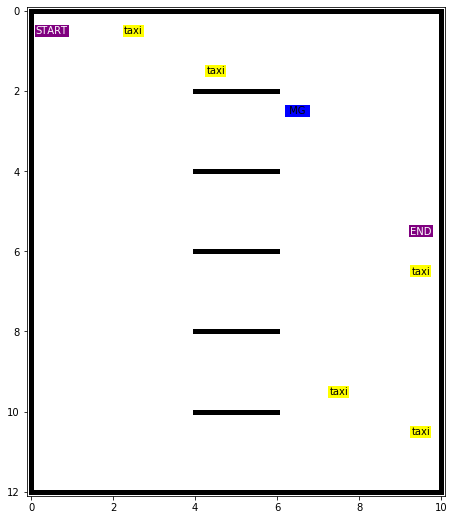

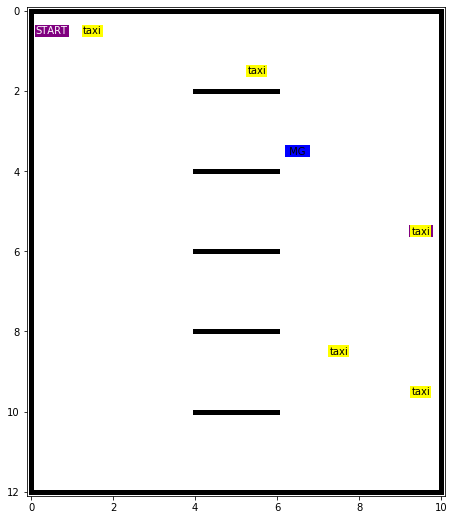

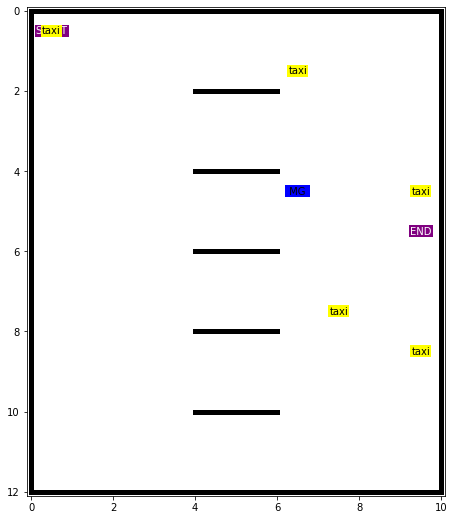

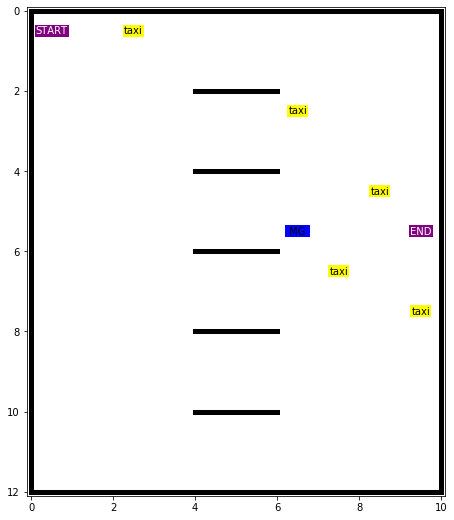

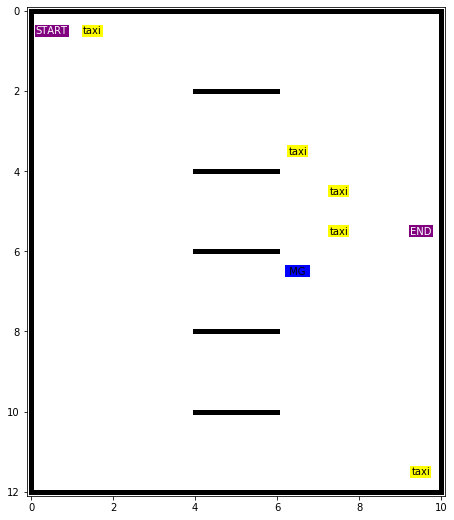

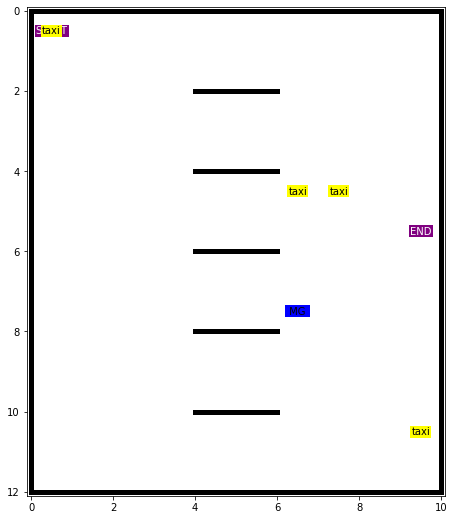

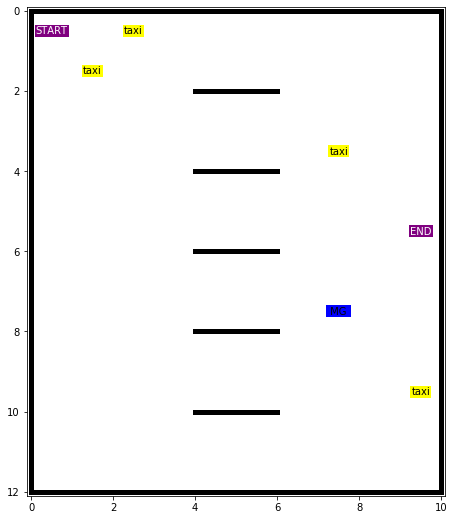

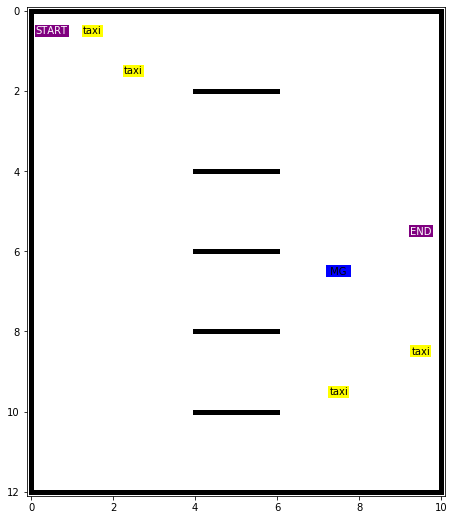

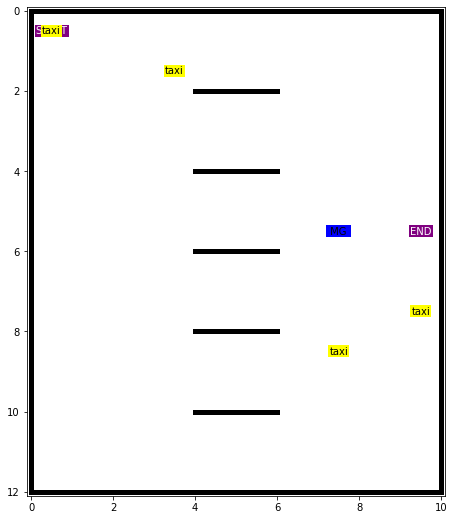

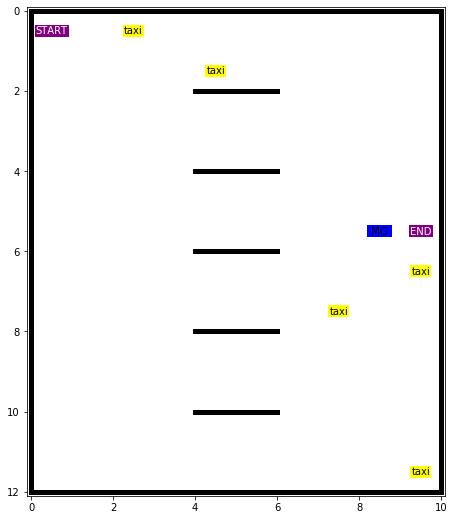

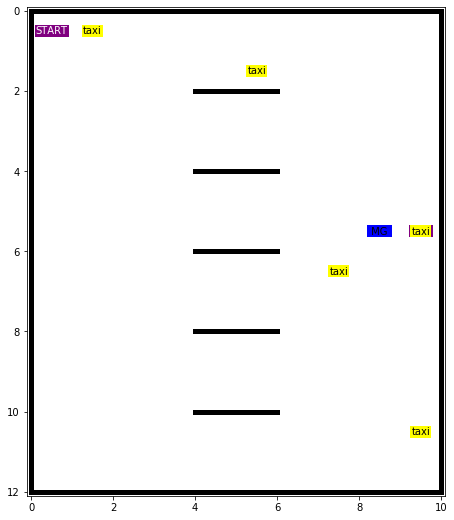

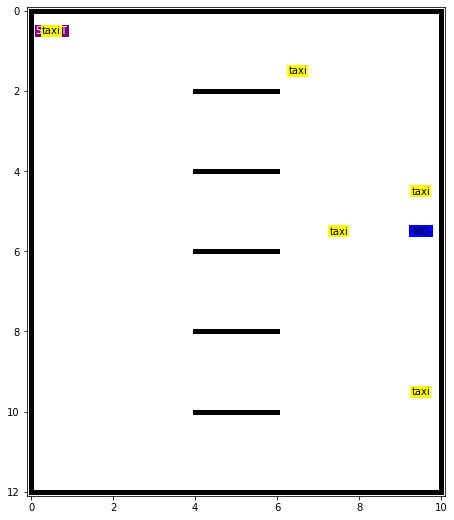

In [5]:
my_grid = Q_learning_dynamic(Q_=my_grid.Q, env=my_grid,
                                print_every_episode=200, n_episodes=100, gamma=0.9, max_steps=500,
                                epsilon=0.5, epsilon_decay=0.99, epsilon_min=0.4, epsilon_decay_every=10, 
                                lr0=1, lr_decay=0.01, min_lr=0.1,display = True)

Ensuite on peut exporter le deplacement de l'IA pour en faire une vidéo qui s'enregistre sous le nom **results.mp4** dans le dossier results

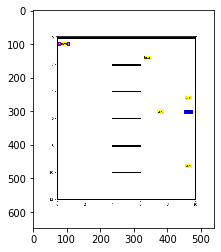

In [6]:
from matplotlib.animation import ArtistAnimation

fig = plt.figure() 
ims = []
for i in range(len(my_grid.path)) :
    im =  plt.imshow(plt.imread("{}.png".format(i)), animated = True)
    ims.append([im])
    os.remove("{}.png".format(i))
ani = ArtistAnimation(fig,ims,interval = 500, repeat_delay = 1000,blit=True)
ani.save("results/results.mp4")
plt.show()

In [25]:
from IPython.display import Video

Video("results/results.mp4")

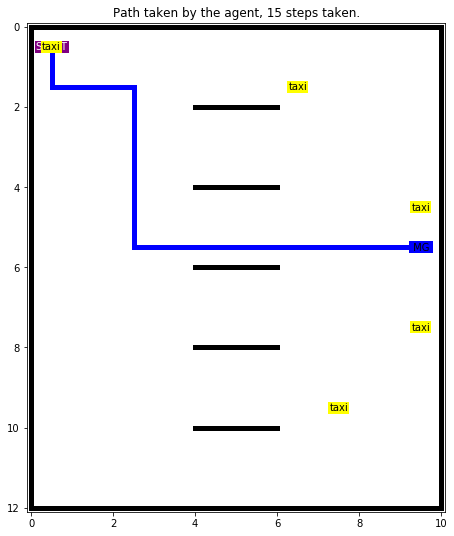

In [26]:
my_grid.render_path()

On voit que le trajet effectué par l'IA n'est pas optimal, cela est du à la policy epsilon greedy qui fait prendre l'IA des décisions parfois aléatoire. <p>
Nous allons donc faire varier les valeurs de epsilon plus proche de 1 dans le but d'avoir un itinéraire plus efficace. On compare alors les temps d'execution et la longueur du trajet

### Avec un epsilon entre 0.2 et 0.5

In [179]:
taxis,long,large = read_data.convert_data (df_taxis,0.1)
my_grid = GridWorld(full_grid_generator(large,long),taxis,(0,0),(3,5))

In [180]:
%%time
my_grid = Q_learning_dynamic(Q_=my_grid.Q, env=my_grid,
                                print_every_episode=200, n_episodes=100, gamma=0.9, max_steps=500,
                                epsilon=0.5, epsilon_decay=0.99, epsilon_min=0.2, epsilon_decay_every=10, 
                                lr0=1, lr_decay=0.01, min_lr=0.1,display = False)

Starting training
100 episodes
Finished  episode 99 of 100 episodes. Mean reward: 0.5 (5.06)
Starting training
100 episodes
Finished  episode 99 of 100 episodes. Mean reward: 0.9 (1.39)
Starting training
100 episodes
Finished  episode 99 of 100 episodes. Mean reward: 0.9 (1.28)
Starting training
100 episodes
Finished  episode 99 of 100 episodes. Mean reward: 1.0 (1.15)
Starting training
100 episodes
Finished  episode 99 of 100 episodes. Mean reward: 0.8 (2.29)
Starting training
100 episodes
Finished  episode 99 of 100 episodes. Mean reward: 0.8 (2.27)
Starting training
100 episodes
Finished  episode 99 of 100 episodes. Mean reward: 0.8 (2.34)
Starting training
100 episodes
Finished  episode 99 of 100 episodes. Mean reward: 0.9 (1.80)
Starting training
100 episodes
Finished  episode 99 of 100 episodes. Mean reward: 0.9 (2.02)
Starting training
100 episodes
Finished  episode 99 of 100 episodes. Mean reward: 0.9 (1.78)
Starting training
100 episodes
Finished  episode 99 of 100 episodes. M

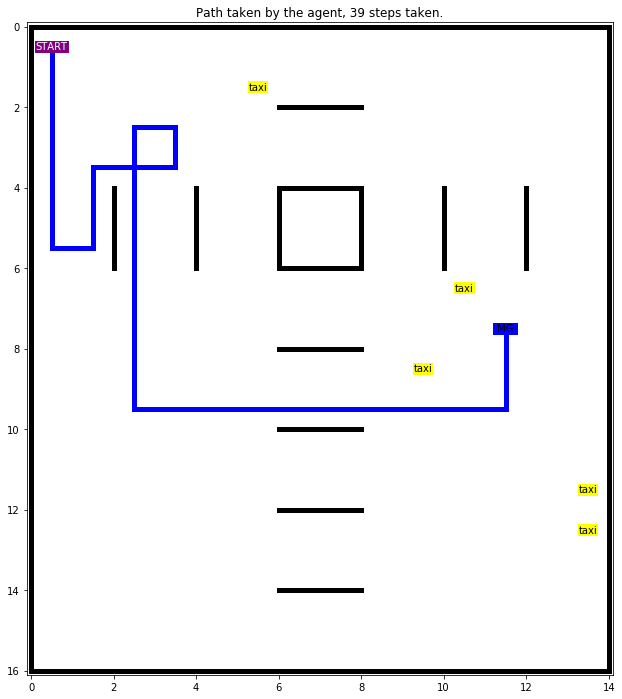

In [181]:
my_grid.render_path()

In [182]:
len(my_grid.path)

39

Ici on lit un temps autour d'une minute et un chemin de longueur 39

### Avec un epsilon entre 0.8 et 0.9

In [183]:
taxis,long,large = read_data.convert_data (df_taxis,0.1)
my_grid = GridWorld(full_grid_generator(large,long),taxis,(0,0),(3,5))

In [184]:
%%time
my_grid = Q_learning_dynamic(Q_=my_grid.Q, env=my_grid,
                                print_every_episode=200, n_episodes=100, gamma=0.9, max_steps=500,
                                epsilon=0.9, epsilon_decay=0.99, epsilon_min=0.8, epsilon_decay_every=10, 
                                lr0=1, lr_decay=0.01, min_lr=0.1,display = False)

Starting training
100 episodes
Finished  episode 99 of 100 episodes. Mean reward: 0.2 (7.34)
Starting training
100 episodes
Finished  episode 99 of 100 episodes. Mean reward: 0.3 (7.06)
Starting training
100 episodes
Finished  episode 99 of 100 episodes. Mean reward: 0.2 (6.80)
Starting training
100 episodes
Finished  episode 99 of 100 episodes. Mean reward: 0.3 (7.20)
Starting training
100 episodes
Finished  episode 99 of 100 episodes. Mean reward: 0.2 (6.57)
Starting training
100 episodes
Finished  episode 99 of 100 episodes. Mean reward: 0.3 (6.95)
Starting training
100 episodes
Finished  episode 99 of 100 episodes. Mean reward: 0.1 (7.45)
Starting training
100 episodes
Finished  episode 99 of 100 episodes. Mean reward: 0.1 (7.39)
Starting training
100 episodes
Finished  episode 99 of 100 episodes. Mean reward: 0.2 (7.53)
Starting training
100 episodes
Finished  episode 99 of 100 episodes. Mean reward: 0.3 (7.85)
Starting training
100 episodes
Finished  episode 99 of 100 episodes. M

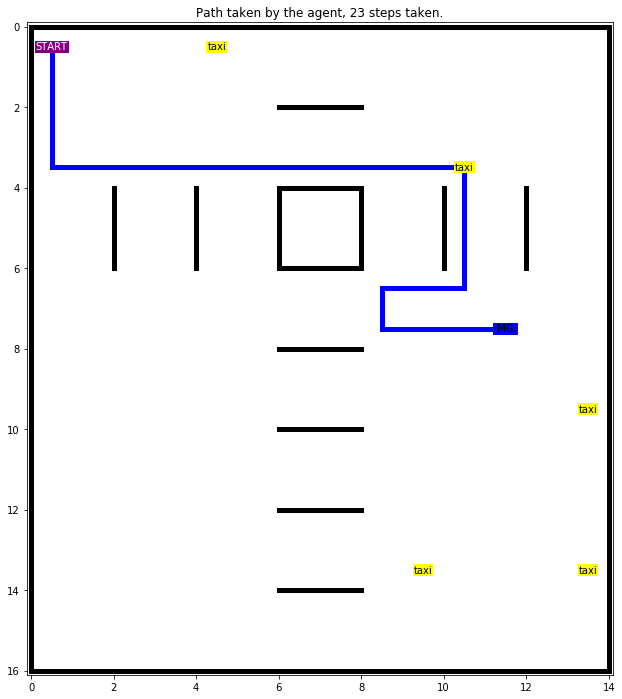

23

In [185]:
my_grid.render_path()
len(my_grid.path)

Pour un espilon plus élevé on trouve ici un temps autour de 2 minutes 30 pour un chemin de longueur 23 (plus élevé car lorsque la désicion n'est pas prise aléatoirement, l'IA doit calculer l'action la plus optimale).

#### Quel espilon choisir ?

Le choix de l'epsilon se fait par un arbitrage entre le temps de réaction de l'IA et le temps de trajet. Un epsilon élevé augmentera d'avantage le temps de réation de l'IA, tandis qu'un epsilon faible augmentera la longueure du trajet.

## Conclusion et extension du modèle

Nous avons réussi à concevoir une IA qui sait trouver son arrivée dans un espace dynamique. Toutefois, un nombre important de taxis sur la grid rend le trajet de l'IA complexe et parfois très long.

La voiture autonome d'aujourdhui fonctionne sur la base du Deep Learning et des réseaux de neurones, car le Q-learning ne permet pas de traiter des problèmes dynamiques aussi complexes que la conduite. La staticité des états est le problème principal du Q-learning et il pourrait sembler opportun de reprendre le problème avec l'idée de le résoudre à l'aide d'un réseau de neurones comme pour la plupart des IA conductrices. Toutefois la simulation du trafic à l'aide des données des taxis semble sans limite dans le sens où les 13 000 taxis qui circulent tous les jours dans New York sont une bonne representation du trafic new yorkais.